# Great Expectations: demo part 1


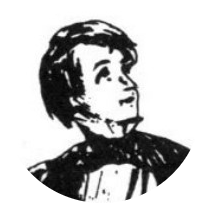


Please set yourself up by:
- Cloning the git repository from GitHub: https://github.com/heineken-advanced-analytics/great-expectation-workshop-pydata.git (shared through chat).
- Read the README for installation instructions.
- Navigate to this notebook: ```workshop-pydata-part1.ipynb```.

In this part we cover:
- How we can implement a simple data validation pipeline with GE through its API.
- Which expectations are built in and how to use them.
- How custom expectations can be implemented.

In [ ]:
from typing import Dict, List
import pandas as pd

# We will be using Great Expectations compatible with pandas.
import great_expectations as ge
from great_expectations.dataset import MetaPandasDataset, PandasDataset

In [ ]:
# We start by loading the file that we want to check.
filepath = "data/weather_brasil_201301.csv"
weather_data_df = pd.read_csv(filepath)

In [ ]:
# Familiarize yourself with the data.
weather_data_df.head()

# Building a simple validation pipeline with Great Expectations

- Define the data expectations,
- attach expectations to the data,
- validate data.

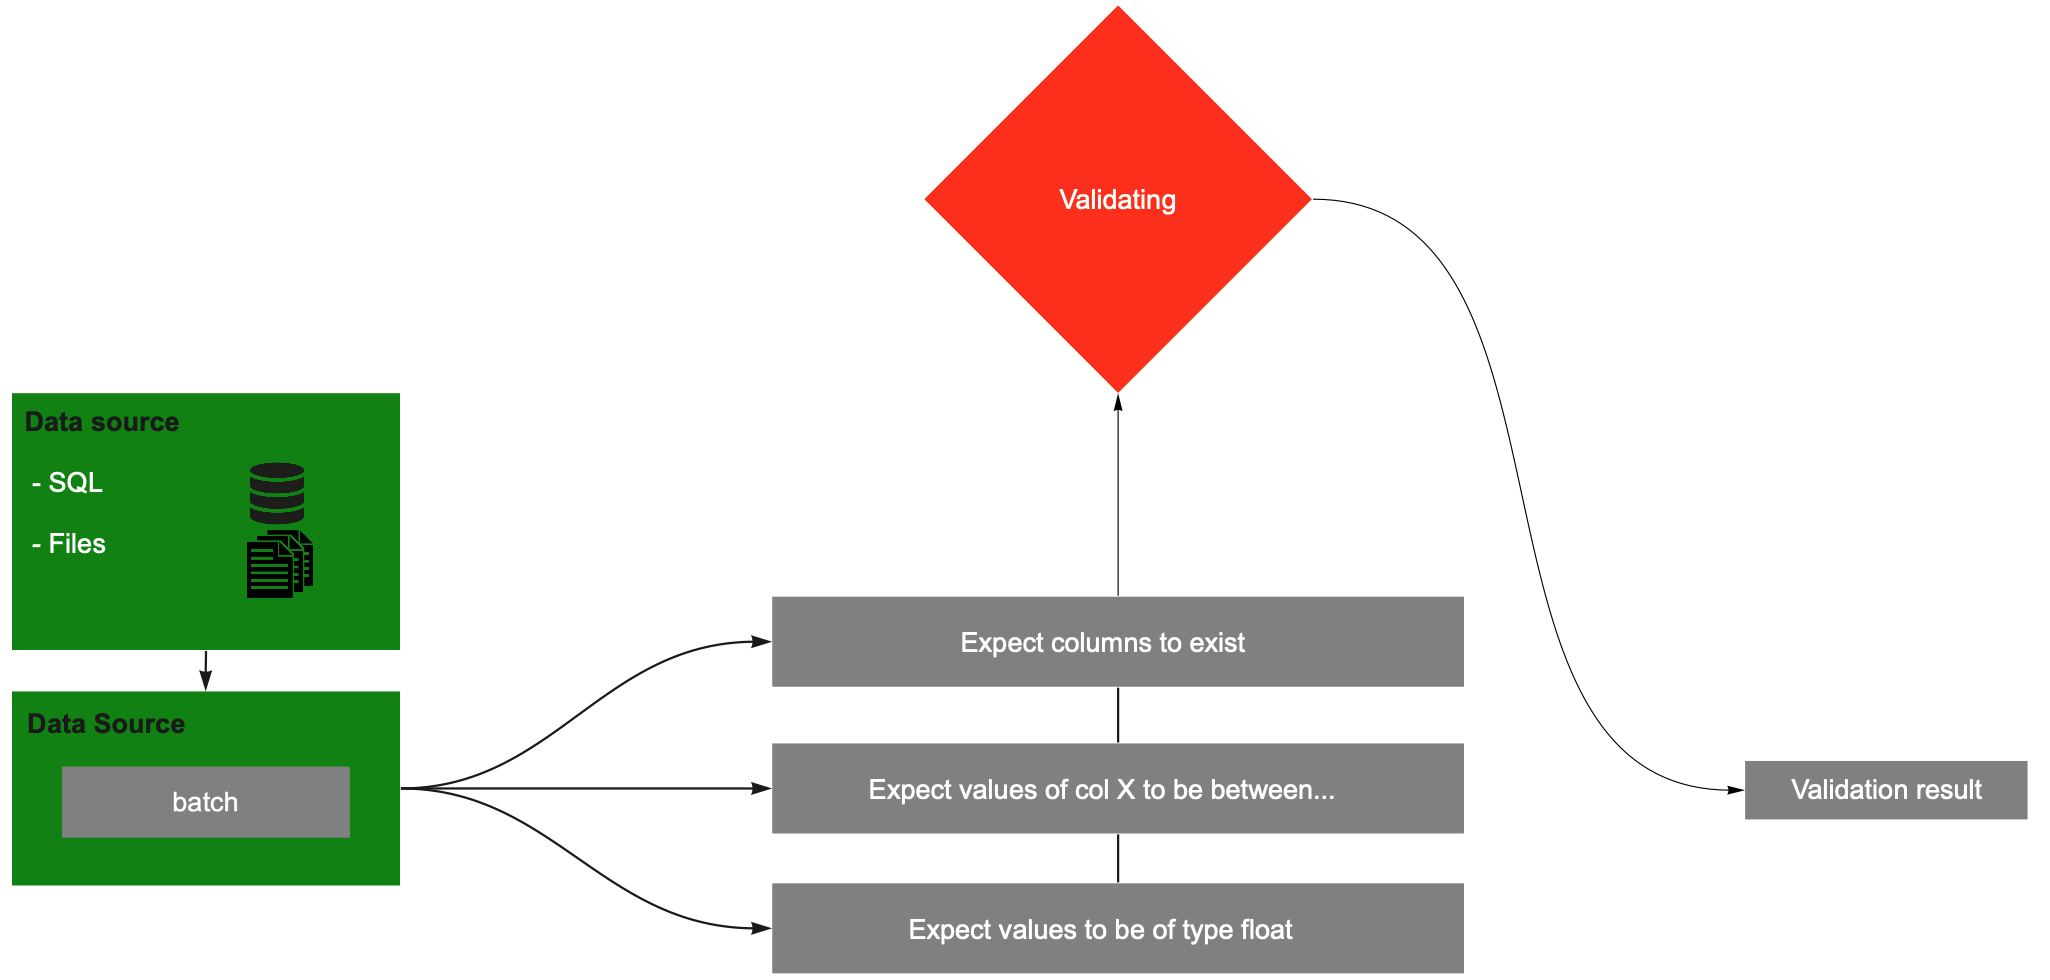

In [ ]:
## We can use GE like pandas as it extends the pandas DataFrame class
batch = ge.read_csv(filepath)
print(type(batch))

In [ ]:
batch.head()

#### Now we can simply attach some built-in expectations of Great Expectations to our dataframe.

In [ ]:
# Name expectations for each column.
required_columns = [
        "id", "elevation", "lat", "lon", "code", "city",
        "timestamp",
        "precip", "air_pres", "solar_rad", "temp", "rel_humid", "wind_speed",
]

In [ ]:
batch.expect_table_columns_to_match_ordered_list(
    column_list=required_columns
);

In [ ]:
# And simply validate the batch against the expectations.
validation_result = batch.validate()
print(validation_result)

In [ ]:
# The overall success indicator of the validation result
validation_result["success"]

#### Let's add some 'domain specific' expectations

In [ ]:
batch.expect_column_values_to_be_between(
    column="temp", min_value=-30, max_value=60
);

In [ ]:
batch.expect_column_values_to_be_between(
    column="lon", min_value=-74, max_value=-34
);

In [ ]:
validation_result = batch.validate()

In [ ]:
validation_result["success"]

In [ ]:
validation_result

# Try it yourself!

For an overview of the built-in expectations:
- Access the docstrings: ```shift-tab``` on ```batch.expect_```.
- Check the glossary: https://docs.greatexpectations.io/en/0.11.4/reference/glossary_of_expectations.html (link shared through chat).

**See if you can add an expectation, for example that the "id" column shoult be of the type "int".**

**Please share your expectation through the chat!**

We will continue in 3 minutes.

# Only those built-in expectations?

If we want, we can specify custom logic and add it as an expectation to our batch. 

We overdid ourselves and created an expectation checking if the given columns hold unique combinations of values.

In [ ]:
batch.head()

In [ ]:
class CustomPandasDataset(PandasDataset):
    
    # setting the _data_asset_type is not required,
    # but helps GE interpreting this as a custom expectation.
    _data_asset_type = "CustomPandasDataset"

    @MetaPandasDataset.multicolumn_map_expectation
    def expect_columns_combination_to_be_unique(
        self, 
        column_list,
        *,
        index=None
    ):
        # A pandas series with a boolean per row is the required output
        # for this multicolumn map expectation format.
        result = pd.Series()

        grouped_df = column_list.groupby(index if index else column_list.columns[0])

        for index, group in grouped_df:
            if not (group.nunique(axis=0) == 1).all(axis=None):
                result = result.append(
                    pd.Series([False for x in range(len(group))]), ignore_index=True
                )
            else:
                result = result.append(
                    pd.Series([True for x in range(len(group))]), ignore_index=True
                )
    
        return result

In [ ]:
batch = ge.read_csv(filepath, dataset_class=CustomPandasDataset)

In [ ]:
type(batch)

In [ ]:
batch.head()

In [ ]:
batch.expect_table_columns_to_match_ordered_list(
    required_columns
);

In [ ]:
batch.expect_column_values_to_be_between(
    column="temp", min_value=-30, max_value=60
);

In [ ]:
batch.expect_column_values_to_be_between(
    column="lon", min_value=-74, max_value=-34
);

In [ ]:
# We check if a weather station always has the same lat/lon.
batch.expect_columns_combination_to_be_unique(
    ["id", "lat", "lon"],
);

In [ ]:
validation_result = batch.validate()
# Now we see the custom expectation in this validation result.
print(validation_result)

## So far the basic flow...


We have seen:
- how we can use Great Expectations to implement built-in expectations, 
- extend functionality with custom expectations, 
- run validations against those expectations, and 
- we inspected the validation output.

Unfortuantely, it is not possible to easily validate incoming batches over time, you would need to add these expectations to a batch every time.

We also have not demonstrated those **neat automated docs** and **fancy validation reports** yet.

Please stay tuned as in part 2 of this workshop, Joost will demonstrate that through the CLI!